# 第5章 微调和引导
微调（fine-tuning）:在新的数据集上重新训练已有的模型，以改变原有的输出类型。
- 从一个已经学会“去噪”的模型开始训练

引导（guidance）：在推理阶段(inference)引导现有模型的生成过程，以获得额外的控制。
- 对一个无生成条件的模型进行引导，生成过程中每一步模型的预测结果都将被一些引导函数评估，并据此加以修改，从而使最终的生成结果符合我们的期望

条件生成：在训练过程中添加一些额外的信息，在推理阶段通过输入相关信息作为条件来控制模型的生成。将条件信息输入模型的方法：
1. 将条件信息作为额外的通道输入UNet模型，这时条件信息与图像具有相同的形状，此时条件信息可以是图像分割的掩码（mask）、深度图或模糊图像（针对图像修复、超分辨率任务的模型）。这种方法也同样适用于其他条件信息，例如类别标签可以映射为嵌入，并展开成具有与输入图像相同的宽度和高度，以作为额外的通道输入模型。
2. 将条件信息转换为嵌入，然后将嵌入通过投影层映射来改变其通道数，从而对齐模型中间层的输出通道数，最后将嵌入加到中间层的输出上。通常情况下，这是将时间步当作条件时的做法。这种方法在有向量形式的条件时很有用，例如CLIP的图像嵌入。
3. 添加带有交叉注意力（cross-attention）机制的网络层，这种方法在条件是某种形式的文本时最有效。例如，如果文本被一个Transformer模型映射为一串嵌入，那么UNet模型中带有交叉注意力机制的网络层就会将这些信息合并到“去噪”路径中。


## 5.1 环境准备

In [ ]:
## !pip install -qq diffusers datasets accelerate wandb open-clip-torch

In [2]:
# Code to log in to the Hugging Face Hub, needed for sharing models
# Make sure you use a token with WRITE access

from huggingface_hub import notebook_login
notebook_login()

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [4]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

## 5.2 载入一个预训练过的管线

In [18]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.19.3",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [26]:
image_pipe.unet

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0

  0%|          | 0/1000 [00:00<?, ?it/s]

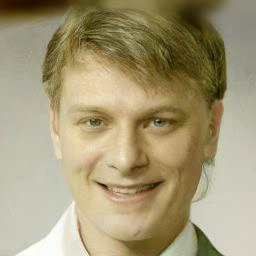

In [19]:
"""
生成图像
"""
images = image_pipe().images
images[0]

## 5.3 DDIM——更快的采样过程

起初，由于模型的预测效果不佳，因此我们需要将这个过程分解为多个步骤。
在Diffusers库中，采样方法由调度器进行控制，每次更新由step()函数来完成。

In [20]:
"""
载入DDIM调度器
"""
# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

In [21]:
# 查看inference推理过程
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

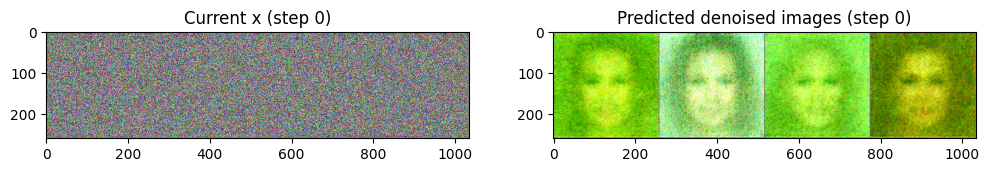

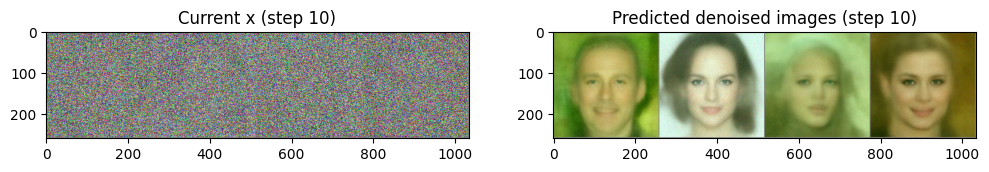

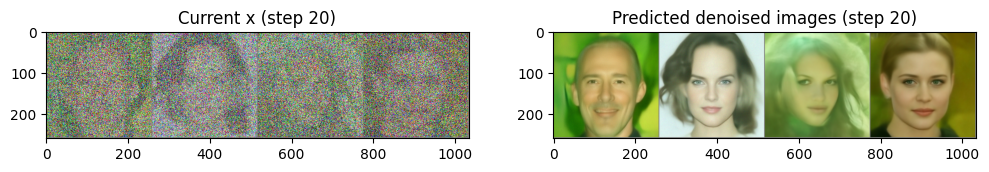

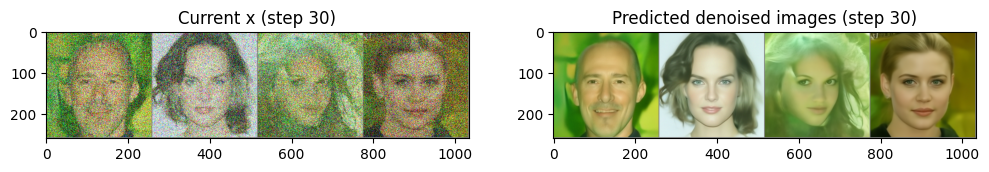

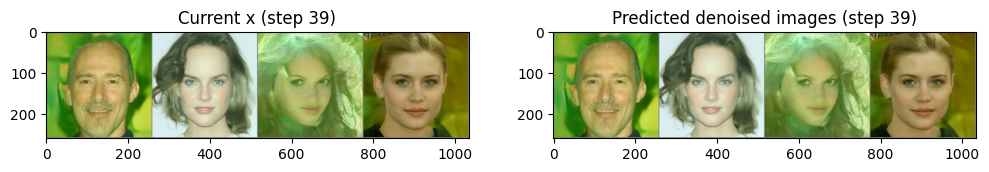

In [22]:
"""
使用4幅随机噪声图片进行循环采样，并观察每一步的输入图像与预测结果的”去噪“版本
-
"""

# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

# Loop through the sampling timesteps（循环一整套时间步）
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input（给“带噪”图像加上时间步信息）
    model_input = scheduler.scale_model_input(x, t)

    # Get the prediction（预测噪声）
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    # 使用调度器计算更新后的样本应该是什么样子
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Update x（更新输入图像）
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = (scheduler_output.pred_original_sample)  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

In [ ]:
# ??scheduler.step

  0%|          | 0/40 [00:00<?, ?it/s]

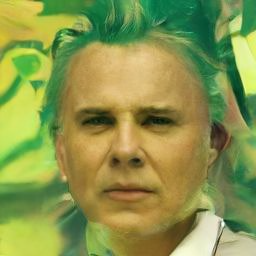

In [24]:
"""
使用新的调度器替换原有管线（pipeline）中的调度器
"""
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

## 5.4 扩散模型之微调

预训练模型：人脸数据上训练出来的

数据集：蝴蝶数据集

Repo card metadata block was not found. Setting CardData to empty.


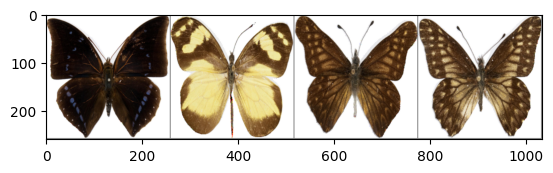

In [25]:
# @markdown load and prepare a dataset:
# Not on Colab? Comments with #@ enable UI tweaks like headings or user inputs
# but can safely be ignored if you're working on a different platform.

# dataset_name = "huggan/smithsonian_butterflies_subset"  # @param
# dataset = load_dataset(dataset_name, split="train")

dataset = load_dataset(path='/home/zhangzq/Downloads/smithsonian_butterflies_subset',data_dir="data",split='train')  # @param
image_size = 256  # @param
batch_size = 4  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

  0%|          | 0/250 [00:00<?, ?it/s]

/home/zhangzq/anaconda3/envs/py3.8/lib/python3.8/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/250 [00:00<?, ?it/s]

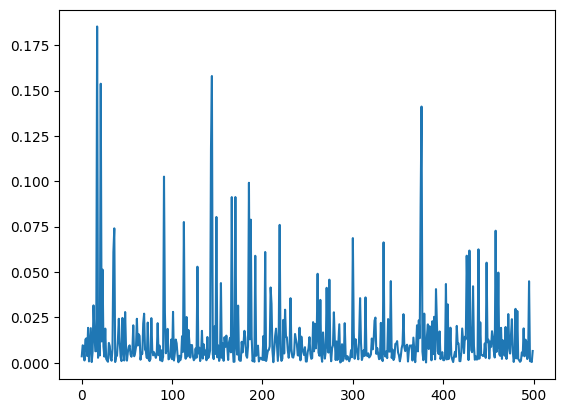

In [27]:
"""

训练过程
- 梯度累积（grad_accumulation）
    - 多运行几次loss.backward()再调用optimizer.step()和optimizer.zero_grad()，这样Pytorch就会累积（即求和）梯度并将多批次数据产生的梯度高效地融合在一起，从而生成一个单一的（更好的）梯度估计值用于参数更新
    - 这种做法可减少参数更新的次数，效果相当于使用更大的batch size进行训练

"""


num_epochs = 2  # @param
lr = 1e-5  # 2param
grad_accumulation_steps = 2  # @param 梯度累积步长

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        # 随机生成一个噪声，稍后加到图像上
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        batch_size = clean_images.shape[0]

        # Sample a random timestep for each image
        # 随机选取一个时间步
        timesteps = torch.randint(0,image_pipe.scheduler.num_train_timesteps,(batch_size,),device=clean_images.device,).long()

        # Add noise to the clean images according to the noise magnitude at each timestep(this is the forward diffusion process)
        # 根据选中的时间步和确定的幅值，在干净图像上添加噪声（此处为前向扩散过程）
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        # 使用“带噪”图像进行网络预测（注意这里是预测噪声）
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        # 对真正的噪声和预测的结果进行比较
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        # 根据损失值更新梯度
        loss.backward(loss)

        # 进行Gradient accumulation（梯度累积），这样既能得到与使用更大batch size一样的收益，又不会造成内存溢出
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}"
    )

# Plot the loss curve:
plt.plot(losses)

使用 Weights & Biases 平台查看训练日志

In [28]:
%wandb johnowhitaker/dm_finetune/2upaa341 # You'll need a W&B account for this to work - skip if you don't want to log in

UsageError: unrecognized arguments: # You'll need a W&B account for this to work - skip if you don't want to log in


0it [00:00, ?it/s]

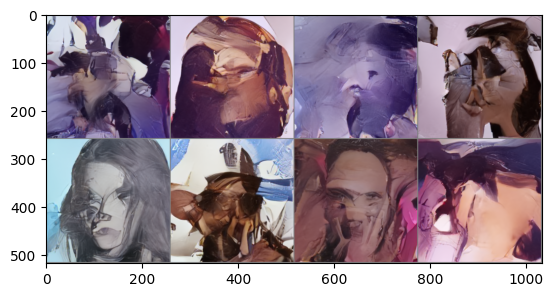

In [30]:
"""
使用模型生成一些图像样本（一些图像中人脸受蝴蝶图像的影响并开始迁移）
"""
# @markdown Generate and plot some images:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

### 5.4.2 使用一个最小化示例程序来微调模型

In [31]:
## 下载微调用的脚本:
# !wget https://github.com/huggingface/diffusion-models-class/raw/main/unit2/finetune_model.py

In [ ]:
## 运行脚本，在Vintage Face数据集上训练脚本
## (最好在终端里跑):
# !python finetune_model.py --image_size 128 --batch_size 8 --num_epochs 16\
#     --grad_accumulation_steps 2 --start_model "google/ddpm-celebahq-256"\
#     --dataset_name "Norod78/Vintage-Faces-FFHQAligned" --wandb_project 'dm-finetune'\
#     --log_samples_every 100 --save_model_every 1000 --model_save_name 'vintageface'

### 5.4.3 保存和载入微调过的管线

In [ ]:
image_pipe.save_pretrained("my-finetuned-model")

In [ ]:
!ls {"my-finetuned-model"}

In [ ]:
"""
将模型上传到hugging face hub
"""

# @title Upload a locally saved pipeline to the hub

# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
model_name = "ddpm-celebahq-finetuned-butterflies-2epochs"  # @param What you want it called on the hub
local_folder_name = "my-finetuned-model"  # @param Created by the script or one you created via image_pipe.save_pretrained('save_name')
description = "Describe your model here"  # @param
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{local_folder_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{local_folder_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

# Add a model card (optional but nice!)
content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Example Fine-Tuned Model for Unit 2 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

{description}

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

## 5.5 扩散模型之引导

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

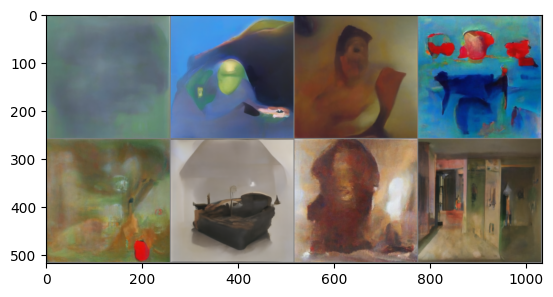

In [34]:
"""
使用在LSUM bedtrooms数据集上训练并在WikiArt数据集上进行一轮微调的新模型
"""

# Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# Random starting point (batch of 8 images)
x = torch.randn(8, 3, 256, 256).to(device)

# Minimal sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the results
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

###  5.5.1 引导

在采样过程中施加额外的控制

In [36]:
"""
创建函数用于定义优化的指标（损失值）
- 下面是让生成的图片趋近于某种颜色的示例，color_loss()函数能够对图片的像素值和目标颜色（浅蓝色）进行比较并返回均方误差
"""
def color_loss(images, target_color=(0.1, 0.9, 0.5)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""

    # Map target color to (-1, 1) tensor([-0.8000,  0.8000,  0.0000])
    target = (torch.tensor(target_color).to(images.device) * 2 - 1)

    # Get shape right to work with the images (b, c, h, w)
    target = target[None, :, None, None]

    # Mean absolute difference(均方误差) between the image pixels and the target color
    error = torch.abs(images - target).mean()
    return error

修改采样循环并执行以下操作（先进行无条件生成$x$，然后根据自定义的优化目标更新$x$）：
1. 创建新的输入图像$x$，将其require_grad属性设置为True
2. 计算“去噪”后的图像$x_{0}$
3. 将“去噪”后的图像$x_{0}$传递给损失函数
4. 计算损失函数对输入图像$x$的梯度
5. 在使用调度器之前，先用计算出来的梯度修改输入图像$x$，使输入图像$x$朝着减少损失值的方向前进

两种方法进行实现：
1. 从UNet中获取噪声预测，并将其设置为输入图像$x$的require_grad属性，这样可以更高效的使用内存（因为不需要通过扩散模型追踪梯度），但会导致梯度的精度降低
2. 先将输入图像$x$的require_grad属性设置为True，然后传递给UNet并计算“去噪”后的图像$x_{0}$

0it [00:00, ?it/s]

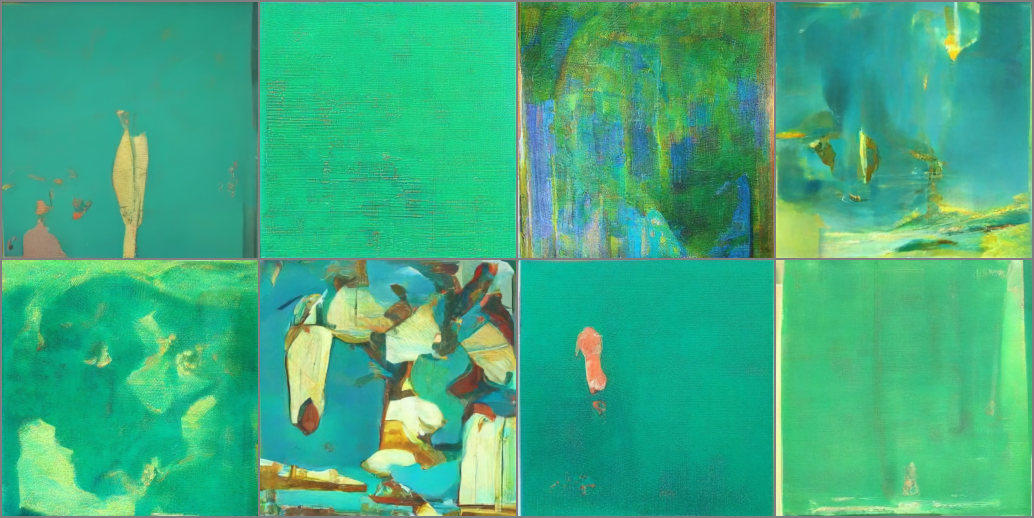

In [37]:
"""
第一种方法
"""

# Variant 1: shortcut method(第一种方法)

# The guidance scale determines the strength of the effect
# 用于决定引导的强度有多大，可通过加大其值来增强颜色迁移的效果
guidance_loss_scale = 40  # Explore changing this to 5, or 100

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare the model input
    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    # 得到去噪后的图像
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient（获得梯度）
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient（使用梯度更新x）
    x = x.detach() + cond_grad

    # Now step with scheduler（使用调度器更新x）
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the output
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

0it [00:00, ?it/s]

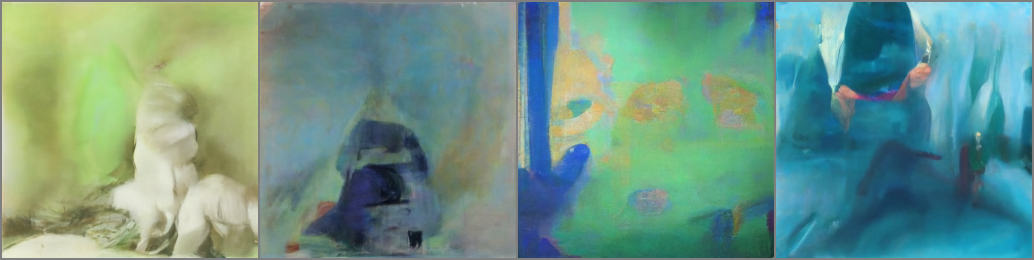

In [38]:
"""
占用的GPU显存更大，结果更精确

"""
# Variant 2: setting x.requires_grad before calculating the model predictions

guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Set requires_grad before the model forward pass
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    # predict (with grad this time)
    noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Get the predicted x0:
    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

###  5.5.2 CLIP 引导

CLIP可以量化一张图和一句提示语的匹配程度，用文字说明引导图片的生成，具体流程：
1. 对文本提示语进行嵌入，为CLIP获取一个512维的嵌入
2. 在扩散模型的生成过程中的每一步执行如下操作
    - 制作多个不同版本的预测出来的“去噪”图片（不同版本的“去噪”图片可以提供更干净的损失信号）
    - 对于预测出的每一张“去噪图片”，用CLIP给图片做嵌入，并使用名为Great Circle Distance Square的度量方法对图片的嵌入和文字的嵌入进行对比
    - 计算损失对于当前“带噪”输入$x$的梯度，在使用调度器更新$x$之前先用这个梯度修改它

In [39]:
"""
使用OpenCLIP载入CLIP模型
"""

# @markdown load a CLIP model and define the loss function
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="openai"
)
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(5),  # One possible random augmentation: skews the image（随机扭曲图片）
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like（随机左右镜像）
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

# And define a loss function that takes an image, embeds it and compares with the text features of the prompt
# 定义一个损失函数，用于获取图片的特征，然后与提示文字的特征进行对比
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(
        tfms(image)
    )  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )  # Squared Great Circle Distance
    return dists.mean()

100%|███████████████████████████████████████| 354M/354M [00:32<00:00, 11.0MiB/s]


0it [00:00, ?it/s]

/home/zhangzq/anaconda3/envs/py3.8/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


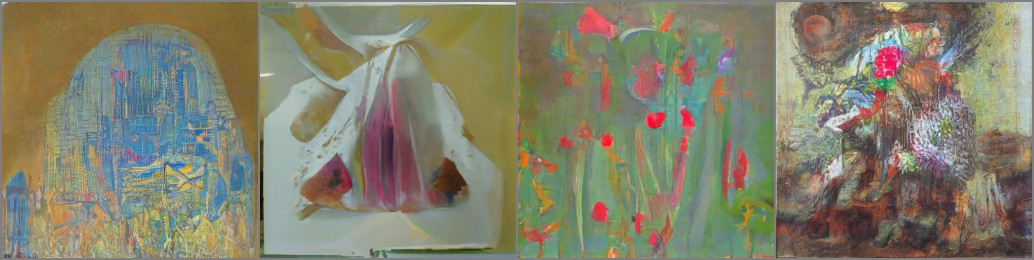

In [40]:
"""
采样循环函数
"""
# @markdown applying guidance using CLIP

prompt = "Red Rose (still life), red flower painting"  # @param

# Explore changing this
guidance_scale = 8  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(50)

# We embed a prompt with CLIP as our target
# 使用CLIP从提示文字中提取特征
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(
    device
)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual（预测噪声）
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        # 获取梯度并使用n_cuts进行平均
        cond_grad = cond_grad-torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    # alpha_bar.sqrt()作为因子来缩放梯度
    alpha_bar = scheduler.alphas_cumprod[i]
    x = (
        x.detach() + cond_grad * alpha_bar.sqrt()
    )  # Note the additional scaling factor here!

    # Now step with scheduler
    # 使用调度器更新x
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

In [ ]:
"""
不同缩放梯度带来的影响
- 对于有些引导来说，可能希望大部分的引导作用集中在刚开始的几步
- 对于关注点在纹理方向的风格损失函数来说，可能希望它们仅仅在生成过程的结束部分加入
"""

# @markdown Plotting some possible schedules:
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod], label="alpha_bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod], label="alpha_bar.sqrt()")
plt.plot(
    [(1 - a).sqrt() for a in scheduler.alphas_cumprod], label="(1-alpha_bar).sqrt()"
)
plt.legend()
plt.title("Possible guidance scaling schedules");

## 5.6 把自定义的采样训练做成 Gradio 上的展示来分享



In [ ]:
!pip install -q gradio # Install the library

In [ ]:
import gradio as gr
from PIL import Image, ImageColor


# The function that does the hard work
def generate(color, guidance_loss_scale):
    target_color = ImageColor.getcolor(color, "RGB")  # Target color as RGB
    target_color = [a / 255 for a in target_color]  # Rescale from (0, 255) to (0, 1)
    x = torch.randn(1, 3, 256, 256).to(device)
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        model_input = scheduler.scale_model_input(x, t)
        with torch.no_grad():
            noise_pred = image_pipe.unet(model_input, t)["sample"]
        x = x.detach().requires_grad_()
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample
        loss = color_loss(x0, target_color) * guidance_loss_scale
        cond_grad = -torch.autograd.grad(loss, x)[0]
        x = x.detach() + cond_grad
        x = scheduler.step(noise_pred, t, x).prev_sample
    grid = torchvision.utils.make_grid(x, nrow=4)
    im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
    im = Image.fromarray(np.array(im * 255).astype(np.uint8))
    im.save("test.jpeg")
    return im


# See the gradio docs for the types of inputs and outputs available
inputs = [
    gr.ColorPicker(label="color", value="55FFAA"),  # Add any inputs you need here
    gr.Slider(label="guidance_scale", minimum=0, maximum=30, value=3),
]
outputs = gr.Image(label="result")

# And the minimal interface
demo = gr.Interface(
    fn=generate,
    inputs=inputs,
    outputs=outputs,
    examples=[
        ["#BB2266", 3],
        ["#44CCAA", 5],  # You can provide some example inputs to get people started
    ],
)
demo.launch(debug=True)  # debug=True allows you to see errors and output in Colab

## 5.7 创建一个类别条件扩散模型

在MINIST数据集上训练一个以类别为条件的扩散模型

### 5.7.1 配置和数据准备

In [ ]:
# !pip install -q diffusers

In [43]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

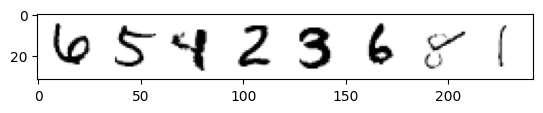

In [44]:
# Load the dataset
dataset = torchvision.datasets.MNIST(
    root="/mnt/71f67401-292d-4824-b42d-45020abbdd27/dataset/d2l/data/MNIST",
    train=True,
    download=False,
    transform=torchvision.transforms.ToTensor())  # 缩放到[0,1]并转为tensor

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [46]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()
    
    # The embedding layer will map the class label to a vector of size class_emb_size
    # 这个网络层会把数字所属的类别映射到一个长度为class_emb_size的特征向量上
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64), 
        down_block_types=( 
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape
    
    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension

    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)

    # Net input is now x and class cond concatenated together along dimension 1
    # 将原始输入和类别信息拼接到一起
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the unet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

### 5.7.3 训练和采样

In [47]:
# Create a scheduler
# DDPMScheduler用于在训练中添加噪声，并在推理时用于采样
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

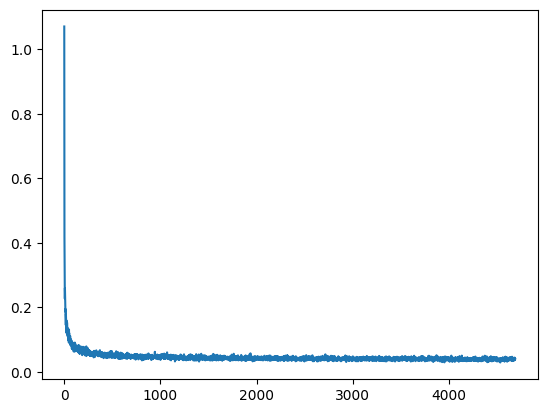

In [48]:
#@markdown Training loop (10 Epochs):

# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network 
net = ClassConditionedUnet().to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in tqdm(train_dataloader):
        
        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

In [61]:
#@markdown Sampling some different digits:

# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
y,y.shape

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
         3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
         6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
         9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0'),
 torch.Size([80]))

In [60]:
noise_scheduler.timesteps

tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 8

0it [00:00, ?it/s]

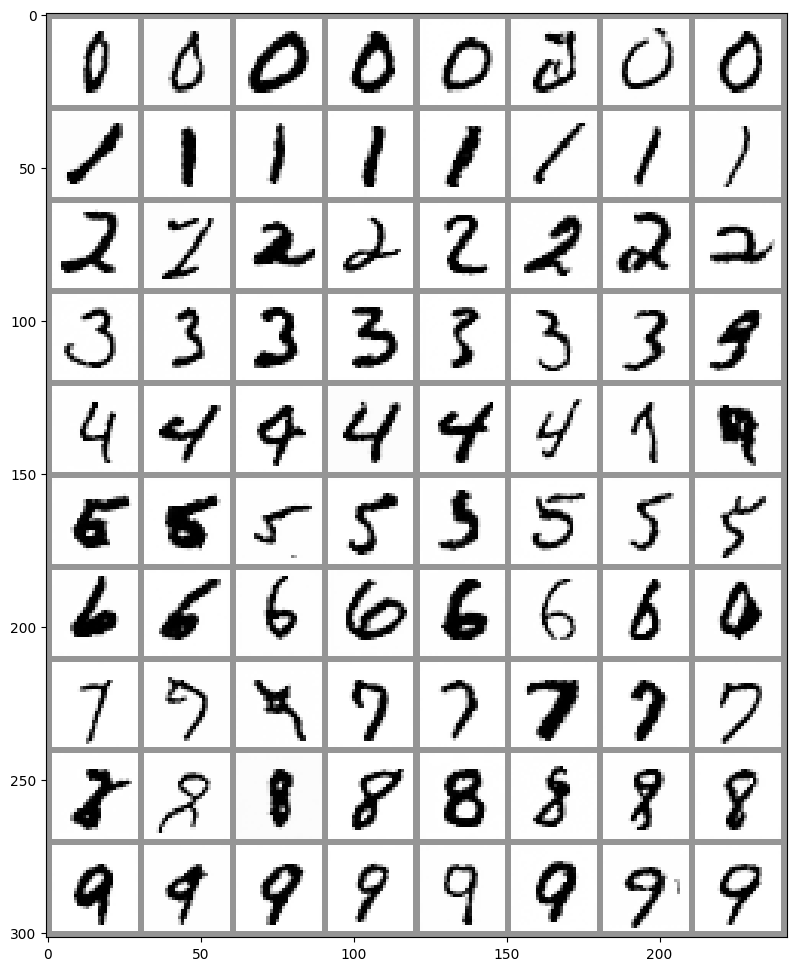

In [62]:
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')